In [1]:
import pandas as pd
import json
from pathlib import Path
from dataclasses import dataclass
from ElasticSettings.topics import create_eval
from datetime import datetime
from functools import partial

### Configure paths

In [2]:
run_folder = Path("runs/")

files = [path for path in run_folder.iterdir() if path.suffix]
folders = [path for path in run_folder.iterdir() if not path.suffix]

eval_files = [path for path in files if path.suffix == ".info"]
run_files = [path for path in files if path.suffix == ".txt"]

# add runs from folders
for folder in folders:
    files_in_folder = [path for path in folder.iterdir() if path.suffix]
    run_files_in_folder = [path for path in files_in_folder if path.suffix == ".txt"]
    
    run_files.extend(run_files_in_folder)

old_run_files = [path for path in run_files if not path.parts[-1].startswith("23")]



### Create evaluations for old files

In [3]:
for path in old_run_files:

    info_path = Path(str(path) + ".info")

    if info_path.exists():
        print(info_path, "already exists. Skipping")
        continue

    try:
        eval = create_eval(qrels_path="data/qrels-covid_d5_j0.5-5_covid-complete.txt", run_path=str(path))
    except:
        print(path)
        continue

    info_dict = {
        "info": path.parts[-1],
        "evaluation": eval
    }
    json.dump(info_dict, open(info_path, "w"))

runs/22.16.12-14_46.txt.info already exists. Skipping
runs/22.16.12-15_41.txt.info already exists. Skipping
runs/22.10.01test_new_analyser26.11-13_00.txt.info already exists. Skipping
runs/22.10.01less_fields26.11-13_03.txt.info already exists. Skipping
runs/22.11.01-13:49.txt.info already exists. Skipping
runs/22.10.01test_new_analyser.txt.info already exists. Skipping
runs/22.10.01test.txt.info already exists. Skipping
runs/22.11.01-13:44.txt.info already exists. Skipping
runs/22.16.12-14_53.txt.info already exists. Skipping
runs/22.11.01-13:21.txt.info already exists. Skipping
runs/22.10.01baseline.txt.info already exists. Skipping
runs/22.16.12-14_48.txt.info already exists. Skipping
runs/22.16.12-15_39.txt.info already exists. Skipping
runs/22.10.01no_operator26.11-13_06.txt.info already exists. Skipping


In [4]:
@dataclass
class Run:
    name: str
    run_path: Path
    info_path: Path
    evaluation: dict
    created: datetime

    @staticmethod
    def from_run_path(run_path: str):
        run_path = Path(run_path)
        info_path = Path(str(run_path) + ".info")
        name = run_path.parts[-1].rstrip(".txt")
        created = datetime.fromtimestamp(run_path.stat().st_ctime)

        evaluation = json.load(open(info_path))["evaluation"]

        return Run(name, run_path, info_path, evaluation, created)

In [104]:
runs = [Run.from_run_path(run_path) for run_path in run_files]

## Run table

In [126]:
data = []
for run in runs:
    run_data = {
        "name": run.name,
        "P\_5": run.evaluation["P_5"],
        "P\_10": run.evaluation["P_10"],
        "P\_20": run.evaluation["P_20"],
        "ndcg": run.evaluation["ndcg"],
        "num\_rel\_ret": int(run.evaluation["num_rel_ret"]),
        "run_obj": run
    }
    data.append(run_data)

run_df = pd.DataFrame(data=data, columns=list(run_data.keys()))

In [127]:
run_df_sorted = run_df.sort_values(by="name").copy()
run_df_sorted = run_df_sorted.reset_index(drop=True).drop([51]).reset_index(drop=True).copy()

In [128]:
run_df_sorted.drop(range(6, 15), inplace=True)
run_df_sorted.drop(range(19, 26), inplace=True)
run_df_sorted = run_df_sorted.reset_index(drop=True)

In [129]:
index = list(range(1, len(run_df_sorted)))
index = pd.DataFrame(["baseline"] + index, columns=["Runs"])
runs_table = run_df_sorted.drop(columns=["run_obj", "name"])
runs_table = pd.concat([index, runs_table], axis=1)
runs_table[runs_table.columns[1:5]] = runs_table[runs_table.columns[1:5]].apply(partial(round, ndigits=3))

In [130]:
runs_table

,Runs,P\_5,P\_10,P\_20,ndcg,num\_rel\_ret
0,baseline,0.512,0.510,0.452,0.362,9420
1,1,0.638,0.617,0.564,0.231,5207
2,2,0.616,0.624,0.578,0.386,9832
3,3,0.057,0.045,0.038,0.031,1130
4,4,0.646,0.560,0.529,0.198,4354
5,5,0.646,0.581,0.569,0.251,5872
6,6,0.296,0.204,0.131,0.030,608
7,7,0.328,0.226,0.137,0.036,817
8,8,0.296,0.204,0.131,0.030,608
9,9,0.468,0.474,0.445,0.383,9965


In [123]:
max_columns_4f = ["P\_5", "P\_10", "P\_20", "ndcg"]
fmts_round = {col: "{:.3f}" for col in max_columns_4f}
fmts = dict(**fmts_round)

In [124]:
latex_table = (
    runs_table.style
    .format(fmts)
    .hide(axis="index")
    .highlight_max(
        subset=runs_table.columns.to_list()[1:],
        color="lightgreen")
).to_latex(
    convert_css=True,
    column_format=" l l l l l l r",
)


In [115]:
def add_hlines(latex, after_rows: list[int]):
    new_latex = ""
    new_latex += latex
    line_breaks = [i for i in range(len(latex)) if latex.startswith("\n", i)]
    for row in sorted(after_rows, reverse=True):
        new_latex = new_latex[:line_breaks[row] + 1] + "\hline" + new_latex[line_breaks[row]:]
    return new_latex

In [116]:
def save_table(table, path):
    with open(path, "w") as fp:
        fp.write(table)

In [117]:
save_table(add_hlines(latex_table, [1, 1, 2]), "latex/run_table_formatted.txt")

## Create plot for decayfunction

In [13]:
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib import rcParams

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
def exp(date, origin, scale, offset, decay):
    y = np.log(decay)/scale
    return np.exp(y * np.max([0, np.abs(date - origin) - offset]))

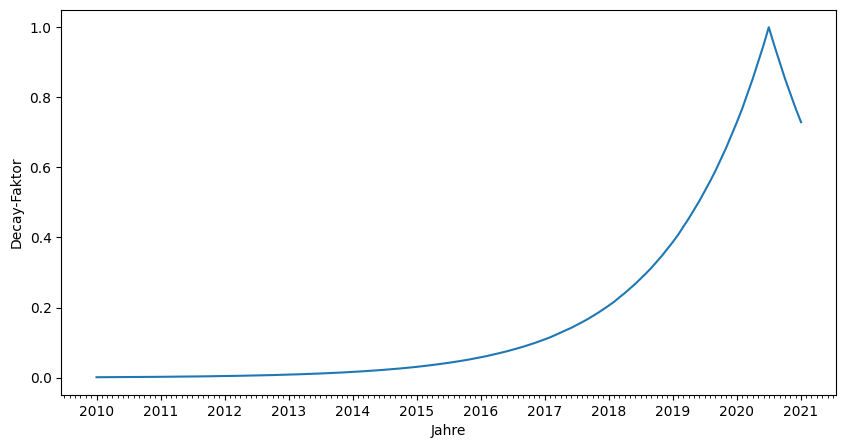

In [33]:

fig, ax = plt.subplots(figsize=(10,5))

months = pd.date_range("2010/01", "2021/01", freq='MS')
number_of_months = len(months)


x = np.arange(0, number_of_months, 1)
y = [exp(date=x_val, origin=number_of_months - 7, scale=2, offset=0, decay=0.9) for x_val in x]

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.plot(months, y)
# ax.set_title(f"Decay function used to rerank documents with \n origin=2020-05, scale=2, offset=0, decay=0.9")
ax.set_xlabel("Jahre")
ax.set_ylabel("Decay-Faktor")


plt.show()


In [34]:
fig.savefig('decay_function.pdf', format="pdf")

### Query tuning

In [63]:
query_run = [run for run in runs if run.name.startswith("23.01.22")][::-1]

In [64]:
data = []
for run in query_run:
    run_data = {
        "P\_5": run.evaluation["P_5"],
        "P\_10": run.evaluation["P_10"],
        "P\_20": run.evaluation["P_20"],
        "ndcg": run.evaluation["ndcg"],
        "map": run.evaluation["map"],
        "num\_rel\_ret": int(run.evaluation["num_rel_ret"]),
    }
    data.append(run_data)

query_df = pd.DataFrame(data=data, columns=list(run_data.keys()))

In [65]:
without = [
    "standart",
    "standart + keywords",
    "standart + keywords - decay",
    "standart - tie breaker",
    "standart - boosting",
    "standart - decay"
]

without_df = pd.DataFrame(without, columns=["Konfiguration"])

In [66]:
query_df = pd.concat([without_df, query_df], axis=1)

In [67]:
query_df[query_df.columns[1:5]] = query_df[query_df.columns[1:5]].apply(partial(round, ndigits=3))

In [68]:
max_columns_4f = ["P\_5", "P\_10", "P\_20", "ndcg", "map"]
fmts_round = {col: "{:.3f}" for col in max_columns_4f}
fmts = dict(**fmts_round)

In [69]:
latex_table = (
    query_df.style
    .format(fmts)
    .hide(axis="index")
    .highlight_max(
        subset=query_df.columns.to_list()[1:],
        color="lightgreen")
).to_latex(
    convert_css=True,
    column_format=" l l l l l l r",
)


In [74]:
def add_hlines(latex, after_rows: list[int]):
    new_latex = ""
    new_latex += latex
    line_breaks = [i for i in range(len(latex)) if latex.startswith("\n", i)]
    for row in sorted(after_rows, reverse=True):
        new_latex = new_latex[:line_breaks[row] + 1] + "\hline" + new_latex[line_breaks[row]:]
    return new_latex

In [75]:
def save_table(table, path):
    with open(path, "w") as fp:
        fp.write(table)

In [76]:
save_table(add_hlines(latex_table, [1]), "latex/query_table_formatted.txt")